##  Data Acquisition and Capstone preview
We fetch Real GDP data from the World Bank API (`NY.GDP.MKTP.KD`).
We will be doing a time series analysis of GDP , we will be using Real GDP with the base year being  2015
GDP is basically measures  the monetary value of final goods and services produced within a country's boarder for a specific period of time usually a year
It is important since it measures  measures the heartbeat of a country's economy.

In [54]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


# API endpoint for Real GDP (constant 2015 US$)
url = 'http://api.worldbank.org/v2/country/KE/indicator/NY.GDP.MKTP.KD?format=json&per_page=1000'
response = requests.get(url)
data = response.json()
records = data[1]

# Convert to DataFrame
df = pd.DataFrame(records)[['date', 'value']].dropna()
df.columns = ['Year', 'Real_GDP']
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index('Year', inplace=True)
df.sort_index(inplace=True)
df.head()

,Real_GDP
Year,
1960-01-01,6.102055e+09
1961-01-01,5.627643e+09
1962-01-01,6.159869e+09
1963-01-01,6.700604e+09
1964-01-01,7.033253e+09


##  Preprocessing
- Converting `Year` to datetime format
- Setting the year as the index
- Check for missing values an  delete them if any

## Exploratory Data Analysis (EDA)
We explore trends, check for stationarity, and visualize components.

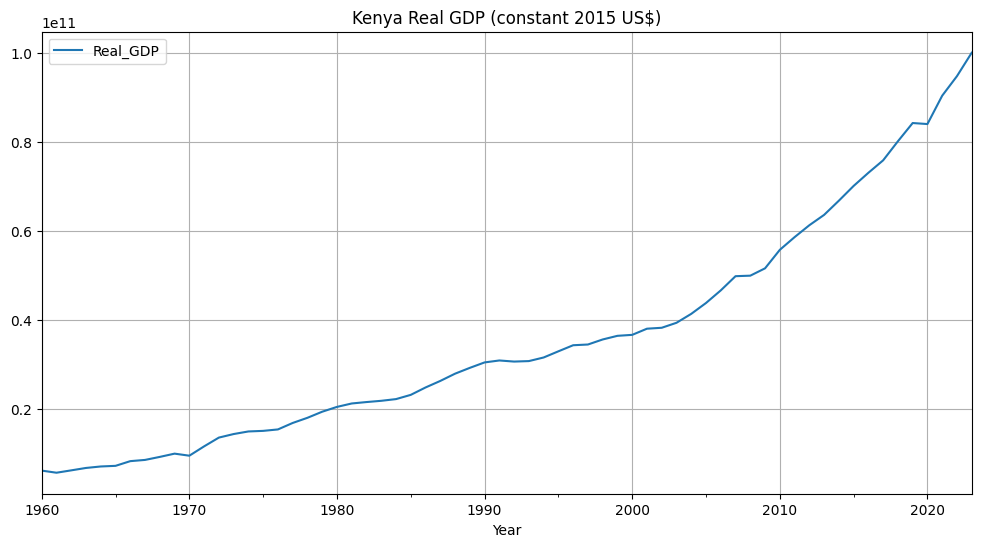

In [55]:
# Plot GDP trend
df.plot(figsize=(12, 6), title='Kenya Real GDP (constant 2015 US$)')
plt.grid(True)
plt.show()

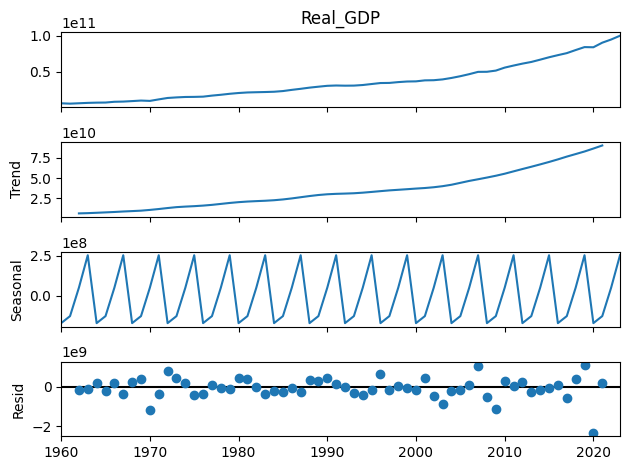

In [56]:



# Decompose trend and seasonality
decomposition = seasonal_decompose(df['Real_GDP'], model='additive', period=4)
decomposition.plot()
plt.tight_layout()
plt.show()



## Differencing to Achieve Stationarity 

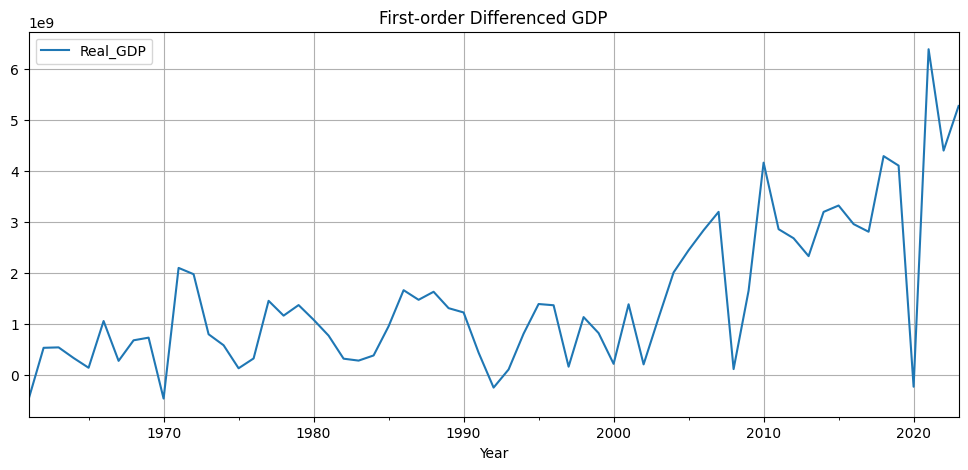

In [57]:
df_diff = df.diff().dropna()
df_diff.plot(figsize=(12, 5), title='First-order Differenced GDP')
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>

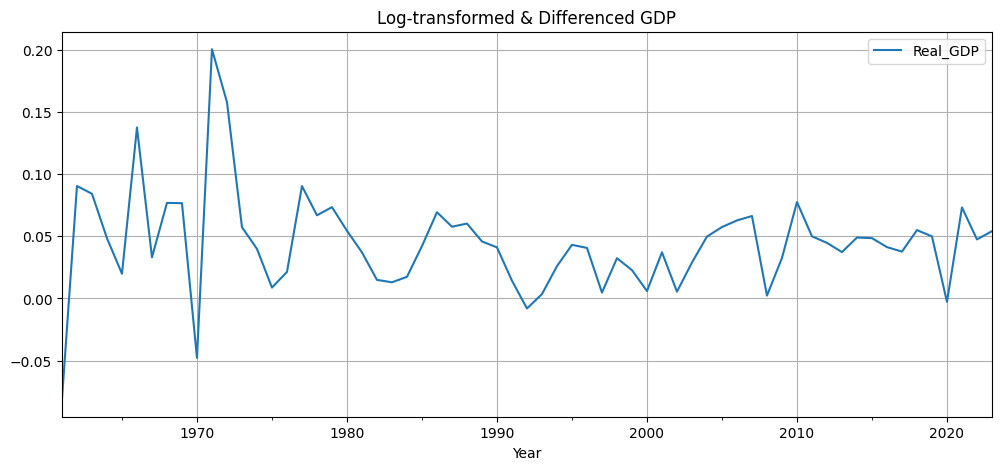

In [58]:
# Step 1: Log transform (only if your data is all positive)
df_log = np.log(df)

# Step 2: Second-order differencing of the log-transformed data
df_log_diff = df_log.diff().dropna()

# Plot
df_log_diff.plot(figsize=(12, 5), title='Log-transformed & Differenced GDP')
plt.grid(True)
plt.show()

In [59]:
df.corr()

,Real_GDP
Real_GDP,1.0


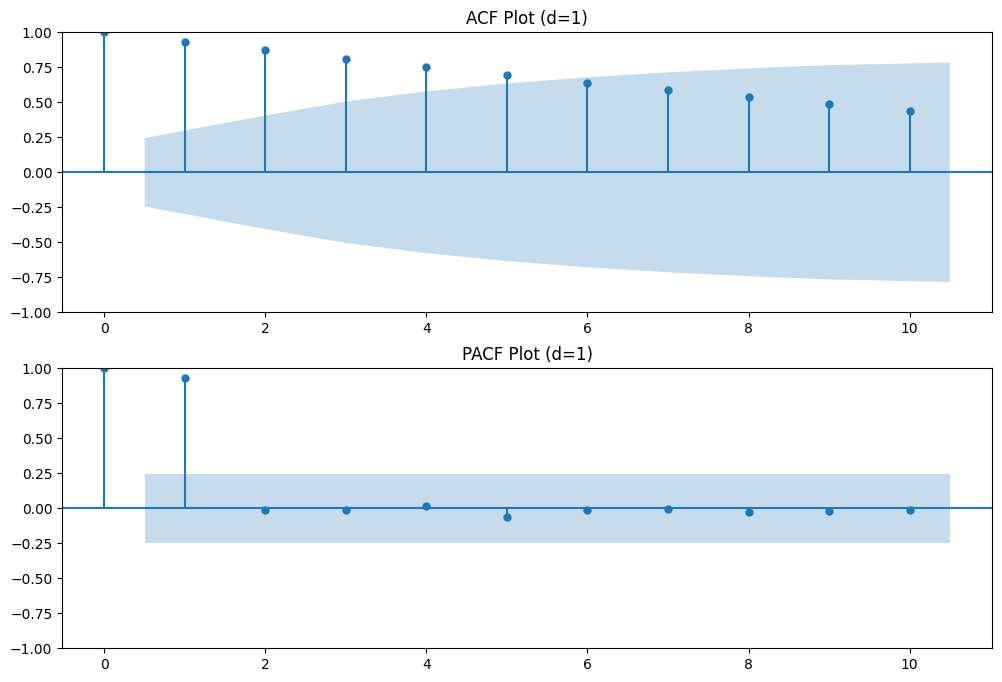

In [60]:
# Plot ACF and PACF for differenced series
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df, lags=10, ax=ax1, title='ACF Plot (d=1)')
plot_pacf(df, lags=10, ax=ax2, method='ywm', title='PACF Plot (d=1)')
plt.show()

## 🤖 ARIMA Forecasting

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary sta

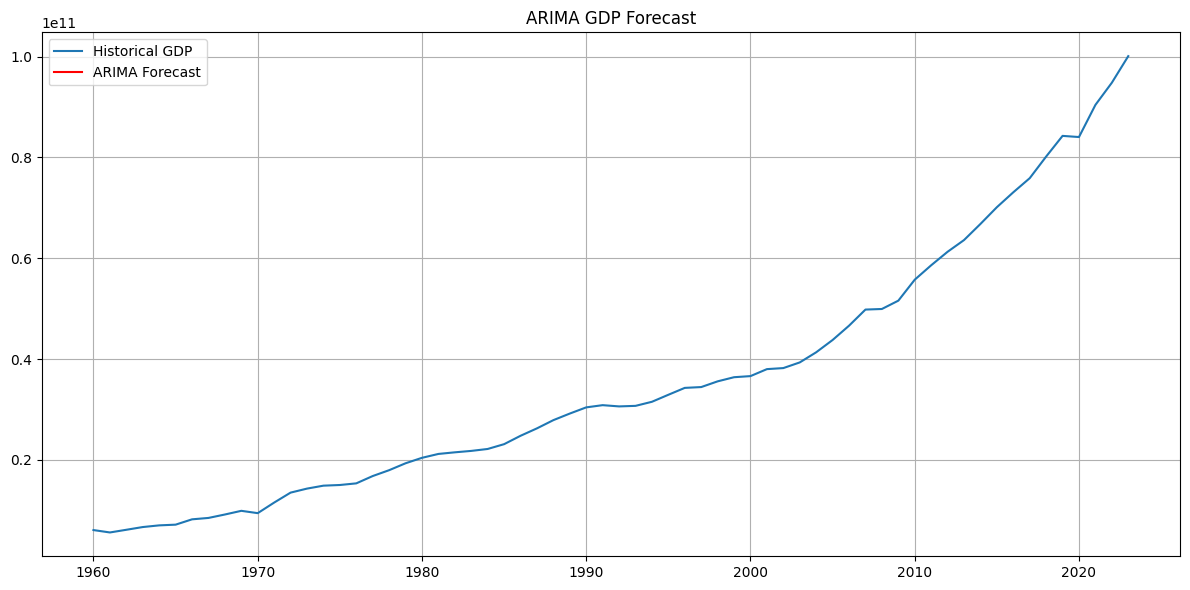

In [61]:
from statsmodels.tsa.arima.model import ARIMA

model_arima = ARIMA(df['Real_GDP'], order=(1, 1, 1))
model_fit = model_arima.fit()

forecast_steps = 10
forecast_arima = model_fit.forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=df.index[-1] + pd.DateOffset(years=1), periods=forecast_steps, freq='Y')

forecast_df = pd.DataFrame({'Forecasted GDP': forecast_arima}, index=forecast_index)

plt.figure(figsize=(12, 6))
plt.plot(df, label='Historical GDP')
plt.plot(forecast_df, label='ARIMA Forecast', color='red')
plt.title('ARIMA GDP Forecast')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 🔮 Prophet Forecasting

23:38:02 - cmdstanpy - INFO - Chain [1] start processing
23:38:02 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


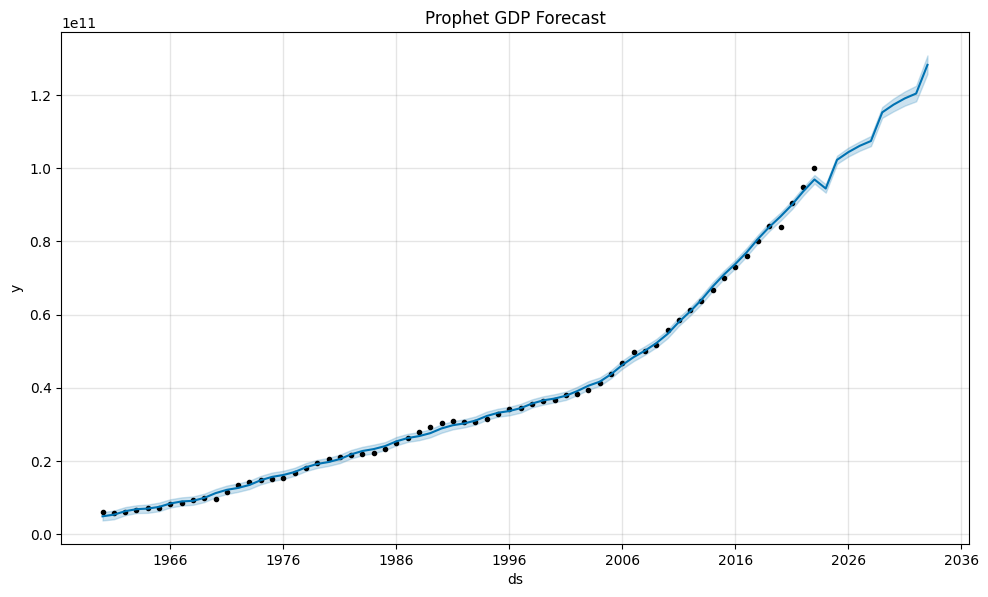

In [62]:
from prophet import Prophet

df_prophet = df.reset_index().rename(columns={'Year': 'ds', 'Real_GDP': 'y'})
model = Prophet()
model.fit(df_prophet)

future = model.make_future_dataframe(periods=10, freq='Y')
forecast = model.predict(future)

fig = model.plot(forecast)
plt.title("Prophet GDP Forecast")
plt.show()

##  Conclusion
- Real GDP shows consistent growth over the decades.
- Both ARIMA and Prophet offer reasonable forecasts.
- Trying to look at a metric like debt to GDP ratio will give us a more  deatailed and informed  health of the economy